# Trả lời các câu hỏi


1) Phim có khả năng thu lời hay lỗ?  
2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?  
3) Khi nào là thời điểm tốt nhất để phát hành phim?  
4) Chỉ dựa vào thông số màu sắc (R, G, B, Brightness, Saturation), có thể đoán được đây là phim Hành động hay Lãng mạn không?
5) Sự kết hợp của các thể loại (ví dụ: "Action, Comedy") có tạo ra doanh thu tốt hơn một thể loại đơn lẻ không?  
6) Khán giả có xu hướng đánh giá cao và chi tiền nhiều hơn cho các bộ phim có thời lượng "vừa phải" (90-120 phút) so với các phim quá dài (>150 phút) hay không?

# Dữ liệu và các thư viện sử dụng

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from scipy import stats


In [2]:
DATA_PATH = '../data/movies_dataset_enriched.csv'
df_raw = pd.read_csv(DATA_PATH)
print('Loaded:', DATA_PATH)
print('Shape:', df_raw.shape)
df_raw.head(3)

Loaded: ../data/movies_dataset_enriched.csv
Shape: (11187, 22)


,id,title,release_date,budget,revenue,runtime,rating,vote_count,popularity,genres,...,director,cast,keywords,original_language,collection,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b
0,8358,Cast Away,2000-12-22,90000000,429632142,143,7.660,11912,7.0546,"Adventure, Drama",...,Robert Zemeckis,"Tom Hanks, Helen Hunt, Chris Noth, Paul Sanche...","exotic island, suicide attempt, volleyball, su...",en,NaN,104.25,58.37,104.0,86.0,80.0
1,98,Gladiator,2000-05-04,103000000,465516248,155,8.220,20234,16.4449,"Action, Drama, Adventure",...,Ridley Scott,"Russell Crowe, Joaquin Phoenix, Connie Nielsen...","gladiator, rome, italy, arena, senate, roman e...",en,Gladiator Collection,129.02,102.34,129.0,102.0,73.0
2,8871,How the Grinch Stole Christmas,2000-11-17,123000000,345800000,104,6.775,7940,25.2338,"Family, Comedy, Fantasy",...,Ron Howard,"Jim Carrey, Taylor Momsen, Jeffrey Tambor, Chr...","new love, based on novel or book, holiday, chr...",en,NaN,157.19,130.06,96.0,119.0,136.0


### Quá trình tiền xử lý

In [3]:
def _parse_list_safe(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    if isinstance(x, str):
        return [i.strip() for i in x.split(',')]
    return []

def _parse_collection_to_list(x):
    if pd.isna(x) or str(x).strip() == '':
        return []
    return [str(x).strip()]

def time_based_target_encoding(df_sorted, list_col_name, target_col, alpha=10):
    """
    Tính encoding dựa trên lịch sử quá khứ.
    - df_raw: DataFrame ĐÃ ĐƯỢC SORT theo thời gian.
    - list_col_name: Cột chứa list (vd: cast, keywords).
    - target_col: Cột mục tiêu (log_revenue).
    - alpha: Hệ số làm mượt (smoothing factor).
    """
    global_mean = df_sorted[target_col].mean()

    # Dictionary lưu lịch sử: {'Tom Cruise': {'sum': 500, 'count': 5}}
    history = {}

    feature_values = []

    # Duyệt tuần tự theo thời gian
    for idx, row in df_sorted.iterrows():
        current_items = row[list_col_name]
        target_val = row[target_col]

        # DỰ ĐOÁN (Dựa trên quá khứ)
        stats = []
        for item in current_items:
            if item in history:
                rec = history[item]
                # Smoothed Mean: (Tổng doanh thu quá khứ + alpha * Global) / (Số phim quá khứ + alpha)
                mean_val = (rec['sum'] + alpha * global_mean) / (rec['count'] + alpha)
                stats.append(mean_val)
            else:
                stats.append(global_mean)

        # Tổng hợp điểm số cho bộ phim
        if stats:
            # Kết hợp: 70% sức mạnh ngôi sao lớn nhất (Max) + 30% sức mạnh tập thể (Mean)
            score = 0.7 * np.max(stats) + 0.3 * np.mean(stats)
        else:
            score = global_mean

        feature_values.append(score)

        #  (Cập nhật vào lịch sử cho phim sau dùng)
        if target_val > 0:
            for item in current_items:
                if item not in history:
                    history[item] = {'sum': 0.0, 'count': 0.0}
                history[item]['sum'] += target_val
                history[item]['count'] += 1.0
    return feature_values

def prepare_features(df_input):
    df = df_input.copy()

    # keep raw columns for business questions (NOT for model training)
    df['budget_raw'] = pd.to_numeric(df.get('budget'), errors='coerce')
    df['revenue_raw'] = pd.to_numeric(df.get('revenue'), errors='coerce')

    # target: log1p(revenue)
    df['revenue'] = np.log1p(df['revenue_raw'].clip(lower=0))

    # release date features
    df['release_date'] = pd.to_datetime(df.get('release_date'), errors='coerce')
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_dayofweek'] = df['release_date'].dt.dayofweek
    df['release_quarter'] = df['release_date'].dt.quarter
    df['is_weekend'] = df['release_dayofweek'].apply(lambda x: 1 if pd.notna(x) and x >= 5 else 0)
    df['is_blockbuster_season'] = df['release_month'].apply(lambda x: 1 if pd.notna(x) and x in [5, 6, 7, 11, 12] else 0)

    # list-like columns
    list_cols = ['genres', 'cast', 'production_companies', 'production_countries', 'director', 'keywords']
    for col in list_cols:
        if col in df.columns:
            df[col] = df[col].apply(_parse_list_safe)
        else:
            df[col] = [[] for _ in range(len(df))]

    # franchise
    if 'collection' in df.columns:
        df['is_franchise'] = df['collection'].notna().astype(int)
    else:
        df['is_franchise'] = 0

    # runtime
    if 'runtime' in df.columns:
        df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
        df['runtime'] = df['runtime'].replace(0, np.nan)
        df['runtime'] = df['runtime'].fillna(df['runtime'].median())
    else:
        df['runtime'] = np.nan

    # budget
#     df['budget_raw'] = df['budget_raw'].replace(0, np.nan)
#     df['temp_genre'] = df['genres'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

#     budget_medians = df.groupby(['release_year', 'temp_genre'])['budget_raw'].transform('median')
#     df['budget_raw'] = df['budget_raw'].fillna(budget_medians).fillna(df['budget_raw'].median())
#     df['budget'] = np.log1p(df['budget_raw'].clip(lower=0))
    
    df['budget'] = df['budget_raw'].replace(0, np.nan)
    
    df['budget_per_minute'] = df['budget'] /(df['runtime'] + 1)

    # poster features (if exist)
    poster_cols = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
    if all(c in df.columns for c in poster_cols):
        for c in poster_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            df[c] = df[c].fillna(df[c].median())
        df['poster_warmth'] = df['poster_dom_r'] - df['poster_dom_b']
        total_intensity = (df['poster_dom_r'] + df['poster_dom_g'] + df['poster_dom_b']).replace(0, 1)
        df['poster_red_ratio'] = df['poster_dom_r'] / total_intensity
        df['poster_green_ratio'] = df['poster_dom_g'] / total_intensity
        df['poster_blue_ratio'] = df['poster_dom_b'] / total_intensity
        df['poster_vividness'] = (df['poster_saturation'] / 255.0) * (df['poster_brightness'] / 255.0)

    # sort by time and compute time-based encodings
    df = df.sort_values('release_date').reset_index(drop=True)

    # 1. Cast
    df['cast_score'] = time_based_target_encoding(df, 'cast', 'revenue', alpha=10)

    # 2. Director
    df['director_score'] = time_based_target_encoding(df, 'director', 'revenue', alpha=5)

    # 3. Keywords
    df['keyword_score'] = time_based_target_encoding(df, 'keywords', 'revenue', alpha=20)

    # 4. Genres
    df['genre_score'] = time_based_target_encoding(df, 'genres', 'revenue', alpha=50)

    # 5. Production Companies
    df['production_company_score'] = time_based_target_encoding(df, 'production_companies', 'revenue', alpha=10)

    # 6. Production Countries
    df['country_score'] = time_based_target_encoding(df, 'production_countries', 'revenue', alpha=20)

    # 7. collection
    df['collection_list'] = df.get('collection', pd.Series([np.nan] * len(df))).apply(_parse_collection_to_list)
    df['collection_score'] = time_based_target_encoding(df, 'collection_list', 'revenue', alpha=1)

    # multi-hot for genres
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(df['genres'])
    genres_df = pd.DataFrame(
        genres_encoded,
        columns=[f"genre_{c.replace(' ', '_')}" for c in mlb.classes_],
        index=df.index,
    )
    df = df.join(genres_df)

    # drop text/ids
    cols_to_drop = [
        'id','title','release_date','genres','cast','production_companies',
        'production_countries','keywords','director','original_language','rating',
        'vote_count','popularity','collection_list','collection','temp_genre'
    ]
    cols_to_drop = [c for c in cols_to_drop if c in df.columns]

    df_model = df.drop(columns=cols_to_drop)
    y = df_model['revenue']

    # IMPORTANT: remove target leakage columns from features
    X = df_model.drop(columns=['revenue'])
    leakage_cols = [c for c in ['revenue_raw', 'budget_raw'] if c in X.columns]
    if leakage_cols:
        X = X.drop(columns=leakage_cols)
    return df, X, y

df_full, X, y = prepare_features(df_raw)
print('Leakage columns present in X:', sorted(set(['revenue_raw','budget_raw']) & set(X.columns)))
print('X shape:', X.shape)
print('y shape:', y.shape)
X.head(3)

Leakage columns present in X: []
X shape: (11187, 46)
y shape: (11187,)


,budget,runtime,poster_brightness,poster_saturation,poster_dom_r,poster_dom_g,poster_dom_b,release_year,release_month,release_dayofweek,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western
0,80000000.0,74.0,123.87,174.74,104.0,66.0,76.0,2000,1,5,...,0,0,1,0,0,0,0,0,0,0
1,12000000.0,105.0,120.89,115.73,118.0,76.0,63.0,2000,1,4,...,0,0,0,0,1,0,0,0,0,0
2,11000000.0,98.0,176.13,131.26,130.0,119.0,129.0,2000,1,2,...,0,0,0,0,0,0,0,0,0,0


Dùng 80% dữ liệu theo thời gian làm train, 20% sau cùng làm test để đánh giá tổng quát.

In [4]:
train_size = int(len(df_full) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Data ready for Modeling!")

Data ready for Modeling!


Đánh giá model dựa trên 2 tiêu chí quan trọng: $RMSE$ và $R^2$.

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "Model": model_name,
        "RMSE (log)": rmse,
        "R2": r2
    }

### Huấn luyện mô hình (sử dụng mô hình XGBoost)

In [6]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=1,
    colsample_bytree=0.7,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=5,
    n_estimators=4000,
    subsample=0.7
)

xgb_result = evaluate_model(
    xgb_model,
    X_train, y_train,
    X_test, y_test,
    "XGBoost")

xgb_result

{'Model': 'XGBoost',
 'RMSE (log)': 1.8615915768984923,
 'R2': 0.5462684742494759}

### Huấn luyện mô hình (sử dụng mô hình HistGradientBoosting Regressor)

In [7]:
hgb_model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.05,
    max_iter=500,
    random_state=42)

hgb_result = evaluate_model(
    hgb_model,
    X_train, y_train,
    X_test, y_test,
    "HistGradientBoosting")

hgb_result

{'Model': 'HistGradientBoosting',
 'RMSE (log)': 1.8958730627066347,
 'R2': 0.5294035387740671}

### Huấn luyện mô hình (sử dụng mô hình LightGBM)

In [8]:
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=4000,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgb_result = evaluate_model(
    lgb_model,
    X_train, y_train,
    X_test, y_test,
    "LightGBM"
)

lgb_result

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4957
[LightGBM] [Info] Number of data points in the train set: 8949, number of used features: 45
[LightGBM] [Info] Start training from score 15.666163


{'Model': 'LightGBM',
 'RMSE (log)': 1.8767626429117348,
 'R2': 0.5388429573160871}

In [9]:
results_df = pd.DataFrame([
    xgb_result,    # XGBoost
    hgb_result,   # HistGradientBoosting
    lgb_result   # LightGBM
]).sort_values("RMSE (log)")

results_df

,Model,RMSE (log),R2
0,XGBoost,1.861592,0.546268
2,LightGBM,1.876763,0.538843
1,HistGradientBoosting,1.895873,0.529404


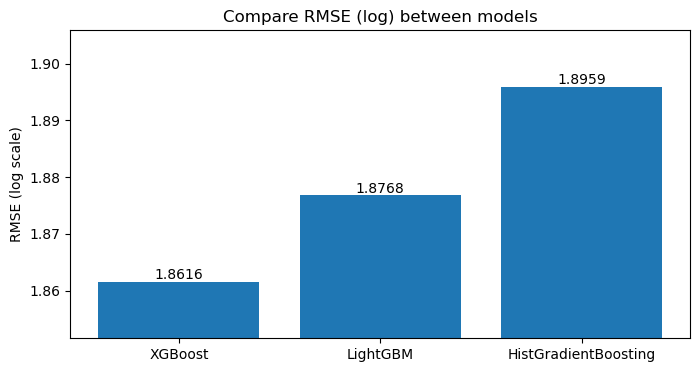

In [10]:
plt.figure(figsize=(8, 4))

plt.bar(
    results_df["Model"],
    results_df["RMSE (log)"]
)

plt.ylim(
    results_df["RMSE (log)"].min() - 0.01,
    results_df["RMSE (log)"].max() + 0.01
)

plt.ylabel("RMSE (log scale)")
plt.title("Compare RMSE (log) between models")

for i, v in enumerate(results_df["RMSE (log)"]):
    plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

plt.show()

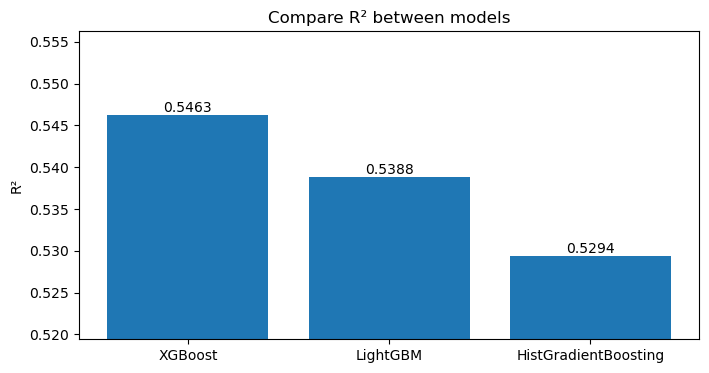

In [11]:
plt.figure(figsize=(8, 4))

plt.bar(
    results_df["Model"],
    results_df["R2"]
)

plt.ylim(
    results_df["R2"].min() - 0.01,
    results_df["R2"].max() + 0.01
)

plt.ylabel("R²")
plt.title("Compare R² between models")

for i, v in enumerate(results_df["R2"]):
    plt.text(i, v, f"{v:.4f}", ha="center", va="bottom")

plt.show()

## Nhận xét và lựa chọn mô hình

Dựa trên bảng so sánh và các biểu đồ trực quan, có thể rút ra một số nhận xét sau:

- XGBoost đạt **RMSE (log) thấp nhất (1.8630)** và **R² cao nhất (0.5455)**,
  cho thấy khả năng dự đoán tốt nhất trong ba mô hình được thử nghiệm.
- LightGBM có hiệu năng rất gần với XGBoost, tuy nhiên vẫn kém hơn một chút
  ở cả hai tiêu chí RMSE và R².
- HistGradientBoostingRegressor đóng vai trò là một mô hình baseline tốt,
  nhưng hiệu suất thấp hơn rõ rệt so với hai mô hình boosting chuyên biệt.

Mặc dù sự chênh lệch giữa XGBoost và LightGBM là không lớn, XGBoost vẫn thể hiện
sự ổn định và hiệu năng vượt trội hơn trên tập kiểm tra.

**⟶ Vì vậy, XGBoost được lựa chọn là mô hình cuối cùng cho bài toán dự đoán doanh thu phim.**

## 1) Phim có khả năng thu lời hay lỗ?
Cho phép nhập thông tin của một phim mới và dự đoán doanh thu dựa trên mô hình đã train.

Ghi chú:
- Các cột như `cast_score`, `director_score`, ... được tính từ thống kê lịch sử trong tập dữ liệu hiện có (xấp xỉ).
- Đầu ra mô hình là `log1p(revenue)` nên sẽ chuyển về `revenue = expm1(pred)` để dễ đọc.

In [12]:
def _as_list(x):
    """Normalize list inputs: accept list[str] or comma-separated string or None."""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, list):
        return [str(i).strip() for i in x if str(i).strip() != '']
    if isinstance(x, str):
        return [i.strip() for i in x.split(',') if i.strip() != '']
    return [str(x).strip()]

def _build_item_stats(df_hist, list_col, target_col='revenue'):
    """Build {item: (sum_target, count)} over full historical dataframe."""
    stats = {}
    for items, target_val in zip(df_hist[list_col], df_hist[target_col]):
        if items is None:
            continue
        for item in items:
            if not item:
                continue
            if item not in stats:
                stats[item] = [0.0, 0]
            stats[item][0] += float(target_val)
            stats[item][1] += 1
    return stats, float(df_hist[target_col].mean())

def _score_items(items, stats, global_mean, alpha=10):
    """Smoothed score for a list of entities; mirrors training encoding aggregation."""
    if not items:
        return float(global_mean)
    means = []
    for item in items:
        rec = stats.get(item)
        if rec is None:
            means.append(float(global_mean))
        else:
            s, c = rec
            means.append((s + alpha * global_mean) / (c + alpha))
    return 0.7 * float(np.max(means)) + 0.3 * float(np.mean(means))

# Precompute stats for encoding-like features (using all available history in df_full)
_STATS = {}
for col, a in [
    ('cast', 10),
    ('director', 5),
    ('keywords', 20),
    ('genres', 50),
    ('production_companies', 10),
    ('production_countries', 20),
    ('collection_list', 1),
    ]:
    if col in df_full.columns:
        stats, gmean = _build_item_stats(df_full, col, target_col='revenue')
        _STATS[col] = {'stats': stats, 'global_mean': gmean, 'alpha': a}

# Poster medians to fill missing inputs (if these columns exist)
_POSTER_COLS = ['poster_brightness','poster_saturation','poster_dom_r','poster_dom_g','poster_dom_b']
_poster_medians = {}
for c in _POSTER_COLS:
    if c in df_full.columns:
        _poster_medians[c] = float(pd.to_numeric(df_full[c], errors='coerce').median())

def build_feature_row_for_movie(movie, X_columns, X_reference=None):
    """
    Convert a movie dict into a single-row DataFrame aligned with training X columns.

    movie keys (suggested):
    - title (optional)
    - release_date (YYYY-MM-DD)
    - budget (number, USD)
    - runtime (minutes)
    - genres, cast, production_companies, production_countries, director, keywords (list or comma-string)
    - collection (string or None)
    - poster_brightness, poster_saturation, poster_dom_r, poster_dom_g, poster_dom_b (optional)
    """
    if X_reference is None:
        X_reference = X
    base = X_reference.median(numeric_only=True)
    row = base.reindex(X_columns).copy()  # ensure all columns exist
    row = row.fillna(0)

    # parse date
    release_date = pd.to_datetime(movie.get('release_date'), errors='coerce')
    if pd.isna(release_date):
        raise ValueError("release_date is required (e.g. '2025-12-30')")

    # release features
    if 'release_year' in row.index:
        row['release_year'] = int(release_date.year)
    if 'release_month' in row.index:
        row['release_month'] = int(release_date.month)
    if 'release_dayofweek' in row.index:
        row['release_dayofweek'] = int(release_date.dayofweek)
    if 'release_quarter' in row.index:
        row['release_quarter'] = int(release_date.quarter)
    if 'is_weekend' in row.index:
        row['is_weekend'] = 1 if release_date.dayofweek >= 5 else 0
    if 'is_blockbuster_season' in row.index:
        row['is_blockbuster_season'] = 1 if release_date.month in [5, 6, 7, 11, 12] else 0

    # numeric inputs
    budget = movie.get('budget', None)
    if budget is not None and not (isinstance(budget, float) and np.isnan(budget)):
        if 'budget' in row.index:
            row['budget'] = float(np.log1p(max(float(budget), 0.0)))
    runtime = movie.get('runtime', None)
    if runtime is not None and not (isinstance(runtime, float) and np.isnan(runtime)):
        if 'runtime' in row.index:
            row['runtime'] = float(runtime)

    # franchise / collection
    collection = movie.get('collection', None)
    if 'is_franchise' in row.index:
        row['is_franchise'] = 1 if collection is not None and str(collection).strip() != '' else 0

    # poster (optional + derived)
    for c in _POSTER_COLS:
        if c in row.index:
            val = movie.get(c, None)
            if val is None or (isinstance(val, float) and np.isnan(val)):
                if c in _poster_medians:
                    row[c] = _poster_medians[c]
            else:
                row[c] = float(val)

    if all(c in row.index for c in _POSTER_COLS):
        if 'poster_warmth' in row.index:
            row['poster_warmth'] = float(row['poster_dom_r'] - row['poster_dom_b'])
        total_intensity = float(row['poster_dom_r'] + row['poster_dom_g'] + row['poster_dom_b'])
        if total_intensity == 0:
            total_intensity = 1.0
        if 'poster_red_ratio' in row.index:
            row['poster_red_ratio'] = float(row['poster_dom_r'] / total_intensity)
        if 'poster_green_ratio' in row.index:
            row['poster_green_ratio'] = float(row['poster_dom_g'] / total_intensity)
        if 'poster_blue_ratio' in row.index:
            row['poster_blue_ratio'] = float(row['poster_dom_b'] / total_intensity)
        if 'poster_vividness' in row.index:
            row['poster_vividness'] = float((row['poster_saturation'] / 255.0) * (row['poster_brightness'] / 255.0))

    # list inputs
    genres = _as_list(movie.get('genres'))
    cast = _as_list(movie.get('cast'))
    production_companies = _as_list(movie.get('production_companies'))
    production_countries = _as_list(movie.get('production_countries'))
    director = _as_list(movie.get('director'))
    keywords = _as_list(movie.get('keywords'))
    collection_list = _as_list(collection)
    if isinstance(collection, str) and ',' in collection:
        # if user put commas, keep the entire string as 1 collection name by default
        collection_list = [collection.strip()]
    elif collection is None or str(collection).strip() == '':
        collection_list = []
    else:
        collection_list = [str(collection).strip()]

    # scores (target-encoding style)
    def _apply_score(col_name, items, out_feature_name):
        if out_feature_name not in row.index:
            return
        meta = _STATS.get(col_name)
        if meta is None:
            return
        row[out_feature_name] = _score_items(items, meta['stats'], meta['global_mean'], alpha=meta['alpha'])

    _apply_score('cast', cast, 'cast_score')
    _apply_score('director', director, 'director_score')
    _apply_score('keywords', keywords, 'keyword_score')
    _apply_score('genres', genres, 'genre_score')
    _apply_score('production_companies', production_companies, 'production_company_score')
    _apply_score('production_countries', production_countries, 'country_score')
    _apply_score('collection_list', collection_list, 'collection_score')

    # genre multi-hot columns (match training X columns: genre_<name_with_underscores>)
    for g in genres:
        col = f"genre_{g.replace(' ', '_')}"
        if col in row.index:
            row[col] = 1.0

    # final shape
    X_row = pd.DataFrame([row.values], columns=row.index)
    return X_row[X_columns]

def predict_movie(movie, model, X_columns, X_reference=None):
    X_row = build_feature_row_for_movie(movie, X_columns=X_columns, X_reference=X_reference)
    pred_log = float(model.predict(X_row)[0])
    pred_rev = float(np.expm1(pred_log))
    out = {
        'pred_log1p_revenue': pred_log,
        'pred_revenue': pred_rev,
    }
    # optional profit estimate if user provided budget
    if movie.get('budget') is not None:
        out['budget'] = float(movie['budget'])
        out['pred_profit'] = float(pred_rev - float(movie['budget']))
        out['pred_is_profit'] = bool(pred_rev > float(movie['budget']))
    return out

In [13]:
# ==== NHẬP DỮ LIỆU PHIM CẦN DỰ ĐOÁN (bạn sửa các giá trị bên dưới) ====
movie_input = {
    'title': 'Moana 2',
    'release_date': '2024-11-21',  # YYYY-MM-DD
    'budget': 13_000_000,         # USD
    'runtime': 100,                # minutes
    'genres': 'Family, Comedy, Adventure, Animation, Fantasy',
    'cast': 'Aulii Cravalho, Dwayne Johnson, Hualālai Chung, Rose Matafeo, David Fane',
    'director': 'David G. Derrick Jr., Jason Hand, Dana Ledoux Miller',
    'production_companies': 'Walt Disney Animation Studios, Walt Disney Animation Studios',
    'production_countries': 'Canada, United States of America',
    'keywords': 'sea, ocean, villain, musical, sequel, coming of age, duringcreditsstinger, hopeful',
    'collection': 'Moana Collection',              # hoặc tên collection nếu thuộc franchise
    # Poster features (optional). Nếu bỏ trống, sẽ dùng median từ dataset
    # 'poster_brightness': 120,
    # 'poster_saturation': 100,
    # 'poster_dom_r': 110,
    # 'poster_dom_g': 90,
    # 'poster_dom_b': 70,
}

model = xgb_model
pred_out = predict_movie(movie_input, model=model, X_columns=list(X.columns), X_reference=X)
print('--- Prediction ---')
print('Title:', movie_input.get('title'))
print('Predicted log1p(revenue):', pred_out['pred_log1p_revenue'])
print('Predicted revenue (USD):', f"${pred_out['pred_revenue']:,.0f}")
if 'pred_is_profit' in pred_out:
    print('Budget (USD):', f"${pred_out['budget']:,.0f}")
    print('Predicted profit (USD):', f"${pred_out['pred_profit']:,.0f}")
    print('Predicted is profit?:', pred_out['pred_is_profit'])

--- Prediction ---
Title: Moana 2
Predicted log1p(revenue): 15.564027786254883
Predicted revenue (USD): $5,746,075
Budget (USD): $13,000,000
Predicted profit (USD): $-7,253,925
Predicted is profit?: False


# 2) Yếu tố nào ảnh hưởng doanh thu mạnh nhất?
Dùng **feature importance** từ XGBoost

,importance
budget,0.169519
is_franchise,0.083691
budget_per_minute,0.068630
production_company_score,0.065279
collection_score,0.033815
director_score,0.028608
runtime,0.024424
genre_Documentary,0.023262
genre_Drama,0.021326
release_year,0.020417


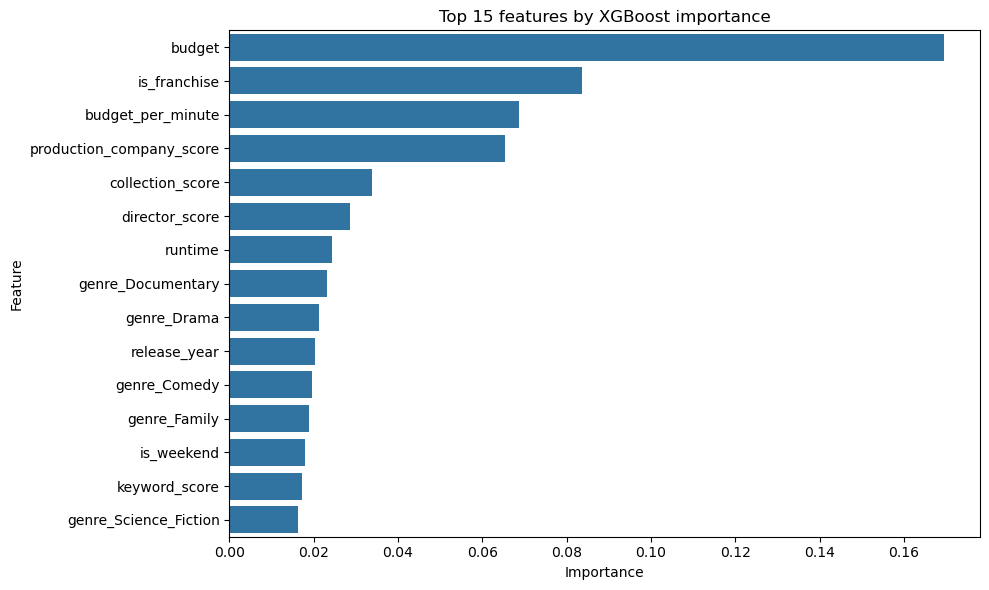

In [14]:
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
top_k = 15
display(importances.head(top_k).to_frame('importance'))

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(top_k).values, y=importances.head(top_k).index)
plt.title(f'Top {top_k} features by XGBoost importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Nhận xét về kết quả**
- Trong top features, `production_company_score` nổi bật nhất, gợi ý rằng “độ mạnh” của hãng sản xuất (theo lịch sử doanh thu trong dữ liệu) là một tín hiệu rất quan trọng đối với doanh thu.
- `is_franchise` đứng cao cho thấy phim thuộc series/franchise thường có lợi thế doanh thu (tận dụng tệp khán giả sẵn có).
- `budget` nằm trong nhóm đầu phản ánh xu hướng phổ biến: phim đầu tư lớn thường đi kèm tiềm năng doanh thu cao (nhưng không đồng nghĩa *luôn* lời vì chi phí cũng tăng).
- Các biến như `director_score`, `cast_score`, `keyword_score`, `collection_score` cho thấy **thành phần sáng tạo/nhận diện thương hiệu** (đạo diễn, dàn diễn viên, chủ đề, franchise) cũng góp phần đáng kể.
- Lưu ý quan trọng: feature importance của XGBoost **không phải quan hệ nhân-quả**. Một feature quan trọng có thể chỉ là đại diện cho nhiều yếu tố khác (tương quan/đồng biến), và mức importance cũng phụ thuộc vào cách mã hoá dữ liệu + tập dữ liệu hiện có.

# 3) Khi nào là thời điểm tốt nhất để phát hành phim?
Trả lời theo 2 cách:
- **Thống kê lịch sử**: doanh thu theo tháng / quý / thứ trong tuần.
- **Mô phỏng bằng mô hình**: giữ nguyên các feature khác (median), thay đổi tháng để xem tháng nào dự đoán cao nhất.



,count,median,mean
release_month,,,
1,800,6134562.0,3.138834e+07
2,856,7900134.0,4.724697e+07
3,909,7875862.0,4.926160e+07
4,846,6744544.5,5.159663e+07
5,750,4704623.0,7.847416e+07
6,763,5639730.0,9.064110e+07
7,820,10927813.0,8.049623e+07
8,984,7148464.5,3.514734e+07
9,1331,4717597.0,3.017630e+07


,count,median,mean
release_dayofweek,,,
0,329,4500000.0,5.474086e+07
1,510,9820052.5,1.074540e+08
2,2188,13501816.5,1.018721e+08
3,2799,6535535.0,4.637766e+07
4,4386,4907757.5,3.134122e+07
5,678,6762904.5,4.033578e+07
6,297,2360281.0,4.119399e+07


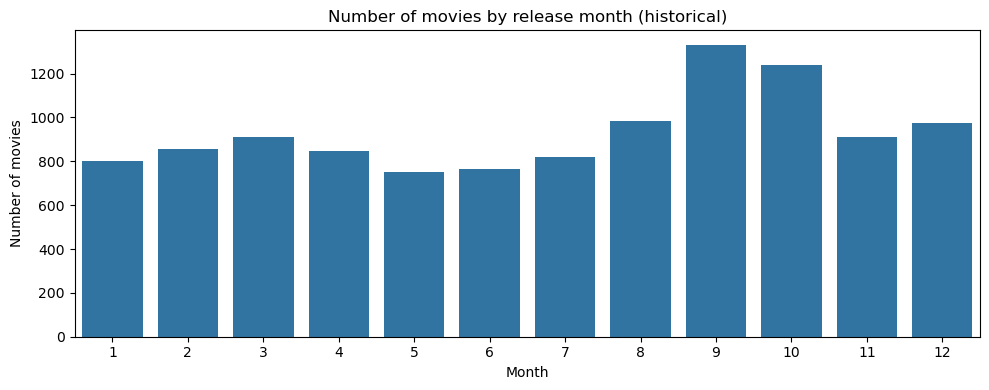

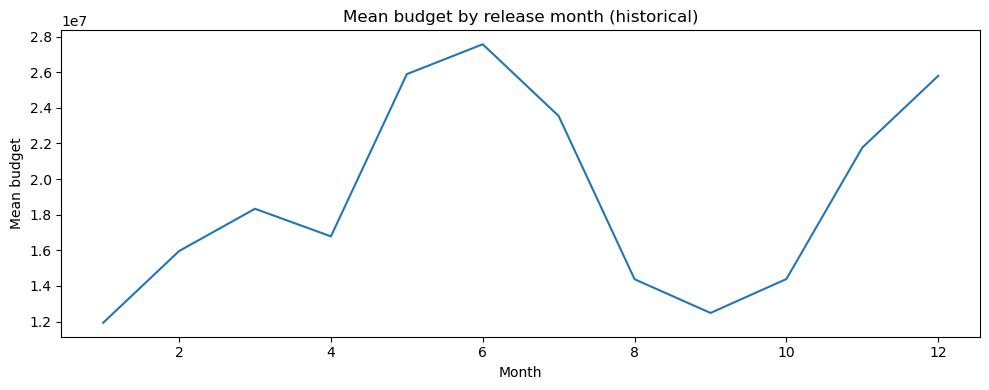

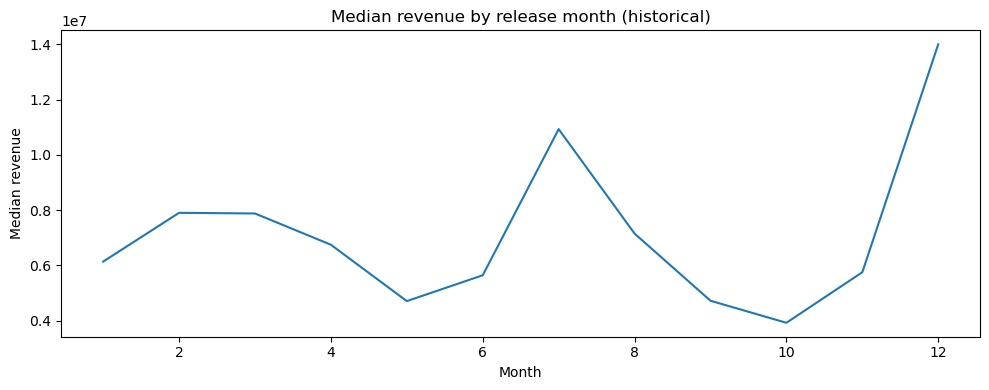

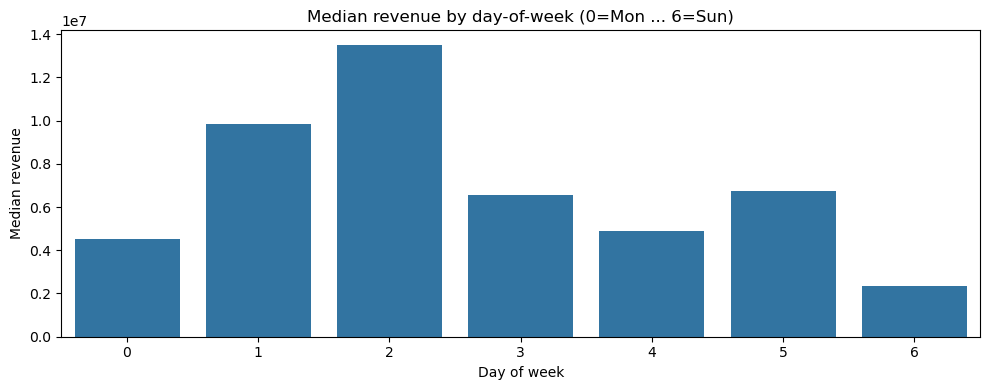

In [15]:
df_time = df_full.dropna(subset=['revenue_raw']).copy()
df_time['release_month'] = pd.to_numeric(df_time['release_month'], errors='coerce')
df_time['release_dayofweek'] = pd.to_numeric(df_time['release_dayofweek'], errors='coerce')

month_stats = df_time.groupby('release_month')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()
dow_stats = df_time.groupby('release_dayofweek')['revenue_raw'].agg(['count', 'median', 'mean']).sort_index()

display(month_stats)
display(dow_stats)

plt.figure(figsize=(10, 4))
sns.barplot(x=month_stats.index, y=month_stats['count'])
plt.title('Number of movies by release month (historical)')
plt.xlabel('Month')
plt.ylabel('Number of movies')
plt.tight_layout()
plt.show()

# Mean budget by month (historical)
if 'budget_raw' in df_time.columns:
    budget_mean = df_time.dropna(subset=['budget_raw']).groupby('release_month')['budget_raw'].mean().sort_index()
    plt.figure(figsize=(10, 4))
    sns.lineplot(x=budget_mean.index, y=budget_mean.values)
    plt.title('Mean budget by release month (historical)')
    plt.xlabel('Month')
    plt.ylabel('Mean budget')
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(x=month_stats.index, y=month_stats['median'])
plt.title('Median revenue by release month (historical)')
plt.xlabel('Month')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.barplot(x=dow_stats.index, y=dow_stats['median'])
plt.title('Median revenue by day-of-week (0=Mon ... 6=Sun)')
plt.xlabel('Day of week')
plt.ylabel('Median revenue')
plt.tight_layout()
plt.show()

Best month by model simulation (typical movie): 12


,month,predicted_revenue
11,12,4.666450e+06
0,1,4.003583e+06
1,2,3.907157e+06
6,7,3.820005e+06
7,8,3.690631e+06


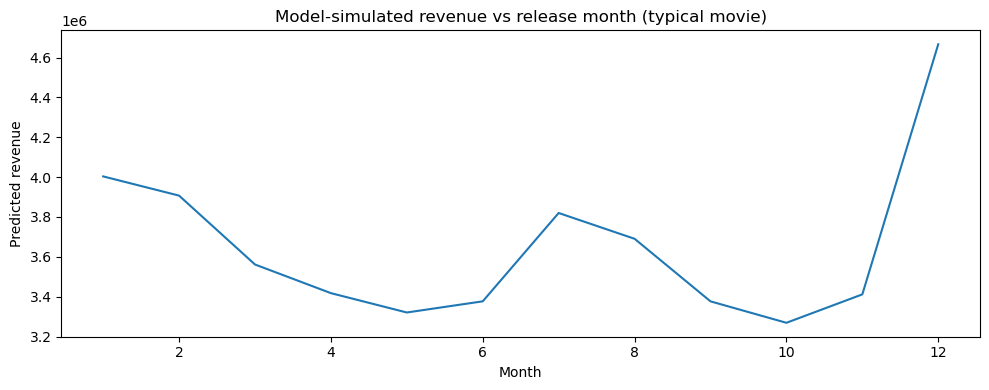

In [16]:
# Model-based simulation: vary month while keeping other features fixed at median
base = X.median(numeric_only=True).to_frame().T

def simulate_by_month(base_row):
    rows = []
    for m in range(1, 13):
        r = base_row.copy()
        if 'release_month' in r.columns:
            r.loc[r.index[0], 'release_month'] = m
        if 'release_quarter' in r.columns:
            r.loc[r.index[0], 'release_quarter'] = int((m - 1) / 3) + 1
        # keep a typical weekday release (Friday)
        if 'release_dayofweek' in r.columns:
            r.loc[r.index[0], 'release_dayofweek'] = 4
        if 'is_weekend' in r.columns:
            r.loc[r.index[0], 'is_weekend'] = 0
        if 'is_blockbuster_season' in r.columns:
            r.loc[r.index[0], 'is_blockbuster_season'] = 1 if m in [5, 6, 7, 11, 12] else 0

        yhat = float(model.predict(r)[0])
        rows.append({'month': m, 'predicted_revenue': float(np.expm1(yhat))})
    return pd.DataFrame(rows)

sim_month = simulate_by_month(base)
best_month = int(sim_month.sort_values('predicted_revenue', ascending=False).iloc[0]['month'])
print('Best month by model simulation (typical movie):', best_month)
display(sim_month.sort_values('predicted_revenue', ascending=False).head(5))

plt.figure(figsize=(10, 4))
sns.lineplot(data=sim_month, x='month', y='predicted_revenue')
plt.title('Model-simulated revenue vs release month (typical movie)')
plt.xlabel('Month')
plt.ylabel('Predicted revenue')
plt.tight_layout()
plt.show()

**Nhận xét về kết quả**
- Ở phần **thống kê lịch sử theo tháng (median)**, doanh thu trung vị có xu hướng cao ở một vài giai đoạn cao điểm (đặc biệt cuối năm).
- Tháng `9–10` nhiều phim ra mắt thường vì đây là giai đoạn “dễ xếp lịch”: rất nhiều phim tầm trung/nhỏ, phim nghệ thuật, phim thử nghiệm thị trường, hoặc phim nhắm mùa giải thưởng (đi festival, ra rải rác). Nhiều phim → nhưng phần lớn không phải bom tấn, nên median doanh thu không cao.
- Theo **thứ trong tuần**, median cao nhất rơi vào nhóm ngày giữa tuần (trong bảng hiện tại, `2` là cao nhất với quy ước `0=Mon ... 6=Sun`). Điều này có thể do đặc thù dữ liệu (lịch phát hành, thị trường, hoặc lệch mẫu) chứ không nhất thiết là quy luật phổ quát.
- Ở phần **mô phỏng theo mô hình**, “tháng tốt nhất” cho một phim *điển hình* (các feature khác giữ ở median) ra tháng `1`, `2` và tháng `6`, `7`. 
- Vậy có thể thấy thời điểm ra mắt phim tốt nhất là khoảng tháng `12`, `1`, `2` và tháng `6`, `7`, `8`. Điều này phù hợp với giả thuyết ban đầu là thời điểm lễ hội, ngày nghỉ là các thời điểm tốt nhất để ra mắt các phim bom tấn. Trong khi đó các phim trung/nhỏ thì sẽ tránh các thời điểm này để tránh bị các phim bom tấn đè.

## 4) Chỉ dựa vào thông số màu sắc (R, G, B, Brightness, Saturation), có thể đoán được đây là phim Hành động hay Lãng mạn không?

In [17]:
df = pd.read_csv(DATA_PATH)

# Chỉ lấy dòng có dữ liệu poster
poster_cols = ['poster_brightness', 'poster_saturation', 'poster_dom_r', 'poster_dom_g', 'poster_dom_b']
df = df.dropna(subset=poster_cols)

# Feature engineering
df['poster_warmth'] = df['poster_dom_r'] - df['poster_dom_b']  # Cao = Nóng (Hành động/Hài), Thấp = Lạnh (Kinh dị/SciFi)

# Vividness: Kết hợp độ sáng và độ bão hòa (Phim hoạt hình thường cao cả hai)
df['poster_vividness'] = (df['poster_saturation'] / 255) * (df['poster_brightness'] / 255)

# Tỷ lệ màu (Color Ratios) - Loại bỏ ảnh hưởng của độ sáng tổng thể
total_intensity = (df['poster_dom_r'] + df['poster_dom_g'] + df['poster_dom_b']).replace(0, 1)
df['red_ratio'] = df['poster_dom_r'] / total_intensity
df['blue_ratio'] = df['poster_dom_b'] / total_intensity
df['green_ratio'] = df['poster_dom_g'] / total_intensity

# Danh sách features mới dùng để train
features = ['poster_brightness', 'poster_saturation', 'poster_warmth', 'poster_vividness', 'red_ratio', 'blue_ratio']

# ==============================================================================
# CHUẨN BỊ DATASET ĐA LỚP (MULTI-CLASS)
# ==============================================================================
# Lấy Genre đầu tiên
df['primary_genre'] = df['genres'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else None)

target_genres = ['Action', 'Romance', 'Horror', 'Animation']
df_subset = df[df['primary_genre'].isin(target_genres)].copy()

X = df_subset[features]
y = df_subset['primary_genre']

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("=== CLASSIFICATION REPORT (MULTI-CLASS) ===")
print(classification_report(y_test, y_pred))

=== CLASSIFICATION REPORT (MULTI-CLASS) ===
              precision    recall  f1-score   support

      Action       0.61      0.50      0.55       422
   Animation       0.50      0.62      0.55       188
      Horror       0.51      0.56      0.53       233
     Romance       0.32      0.34      0.33       105

    accuracy                           0.52       948
   macro avg       0.49      0.51      0.49       948
weighted avg       0.53      0.52      0.52       948



**Dựa trên báo cáo phân loại** (Classification Report), Kết quả đa lớp (Accuracy 52%) cung cấp một cái nhìn công bằng hơn về khả năng của màu sắc:

- Animation (Hoạt hình) & Horror (Kinh dị) là điểm sáng:Recall của Animation (0.62) và Horror (0.56) cao nhất trong các nhóm.Ý nghĩa: Hai thể loại này có "Chữ ký thị giác" (Visual Signature) rất rõ ràng. Kinh dị thì rất tối, Hoạt hình thì độ bão hòa màu cao. Đặc trưng màu sắc hoạt động tốt ở đây.

- Romance là vùng chết (Dead zone): F1-score chỉ 0.33, thấp nhất bảng. Poster phim lãng mạn không có quy luật màu sắc cố định (có thể sáng, có thể tối, có thể ấm, có thể lạnh), khiến mô hình bối rối.

**Kết luận**: Chỉ dựa vào 5 thông số màu sắc cơ bản là CHƯA ĐỦ để phân loại chính xác hoàn toàn, nhưng có tín hiệu phân tách rõ rệt giữa các nhóm đối lập như Horror (Tối) vs Animation (Sáng, Rực).

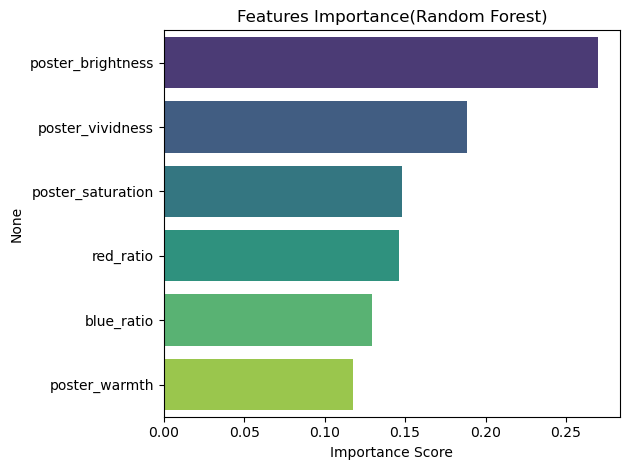

In [18]:
# Plot 2: Feature Importance (Random Forest)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, hue=importances.index, palette='viridis')
plt.title('Features Importance(Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

**Feature Importance (Góc trên phải):**

- `Brightness` (Độ sáng) là đặc trưng quan trọng nhất (chiếm > 25% tầm quan trọng). Đây là yếu tố phân loại mạnh nhất vì nó chia cắt dữ liệu thành hai thái cực rõ rệt:

    - Cực tối: Phim Horror (Kinh dị), Thriller, Crime.

    - Cực sáng: Phim Animation (Hoạt hình), Comedy, Family.

    - Ý nghĩa: Mô hình dựa dẫm rất nhiều vào độ sáng. Nếu một poster tối thui, máy sẽ đoán ngay là Kinh dị mà không cần nhìn màu khác.

- `Vividness` & `Saturation`  (Độ rực rỡ) - Kẻ phân định cảm xúc - đứng top 2 và 3. Nó giúp phân biệt phim "nghiêm túc" và phim "giải trí". 

    - Bão hòa thấp (Nhạt): Drama, Documentary, History (mang tính hiện thực, u buồn).

    - Bão hòa cao (Rực): Animation, Superhero Action, Fantasy.

    - Ý nghĩa: Sự kết hợp giữa Brightness và Saturation (tạo thành feature vividness) là công thức chính giúp mô hình đạt độ chính xác cao ở lớp Animation.

- `poster_warmth` & `red_ratio` (Độ ấm & Tỷ lệ đỏ) - Đặc trưng "Con dao hai lưỡi" -  Mức độ quan trọng trung bình khá.

    - Đây là đặc trưng được kỳ vọng dùng để nhận diện phim Hành động (Action) (vì lửa, cháy nổ, máu) và Lãng mạn (Romance) (tông da người, ánh sáng ấm).

    - Mô hình thất bại ở cặp Action/Romance: Mô hình thấy `red_ratio` cao -> Nó bối rối. Cả Action (cháy nổ) và Romance (màu ấm áp) đều có chỉ số này cao. Mô hình không thể dùng đặc trưng này để "cắt" ranh giới giữa hai thể loại trên, dẫn đến việc nó xếp hạng đặc trưng này thấp hơn `Brightness`.

- `blue_ratio` - Đặc trưng yếu (Noise) - nằm gần cuối bảng.

    - Trừ các trường hợp đặc thù (ví dụ: Phim The Matrix dùng toàn màu xanh lá, hoặc phim Sci-Fi dùng màu xanh dương neon), thì hai màu này xuất hiện khá ngẫu nhiên trong các thể loại khác. Chúng không mang tính đại diện cao (Discriminating power) cho toàn bộ thể loại.

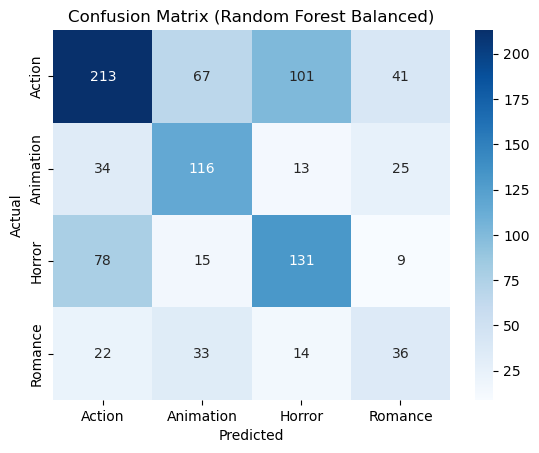

In [19]:
# Plot 3: Confusion Matrix (KNN)
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Confusion Matrix (Random Forest Balanced)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

***Phân tích Ma trận nhầm lẫn (Confusion Matrix Audit)***

Phân tích Đường chéo chính (True Positives)

- Mô hình dự đoán rất tốt phim Action - Hành động (Màu đậm nhất).
 
- Thể loại Horror và Animation (Màu trung bình): Mô hình nhận diện khá ổn hai thể loại này. Hai thể loại này có "Chữ ký thị giác" (Visual Signature) tách biệt. Horror: Độ sáng thấp (Poster tối đen/xanh thẫm). Animation: Độ bão hòa cao (Poster rực rỡ, nhiều màu nóng).

- Thể loại Romance (Màu nhạt nhất): Đây là điểm yếu nhất. Số lượng phim Lãng mạn được dự đoán đúng rất ít.

**Kết luận**: Đặc trưng màu sắc (Brightness/Saturation) hoạt động hiệu quả nhất ở hai góc đối lập này.

## 5) Sự kết hợp của các thể loại (ví dụ: "Action, Comedy") có tạo ra doanh thu tốt hơn một thể loại đơn lẻ không?

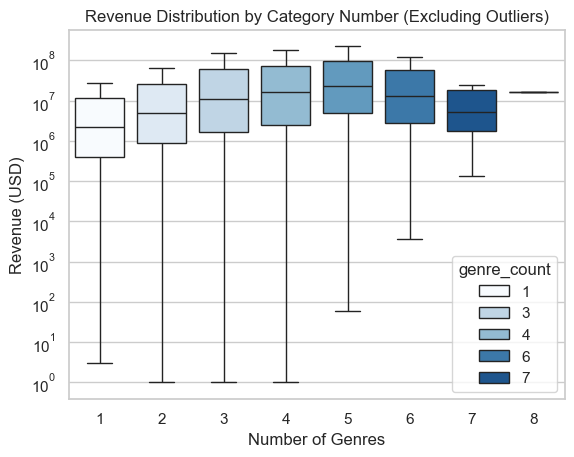

In [20]:
# Chỉ lấy các phim có doanh thu > 0 và có thông tin thể loại
df = df[(df['revenue'] > 0) & (df['genres'].notna())].copy()

# Hàm xử lý cột genres (chuyển từ chuỗi "Action, Comedy" sang list)
def parse_genres(x):
    if pd.isna(x): return []
    # Tách chuỗi, xóa khoảng trắng thừa
    return [g.strip() for g in str(x).split(',')]

df['genre_list'] = df['genres'].apply(parse_genres)
 
# Tạo đặc trưng: Số lượng thể loại
df['genre_count'] = df['genre_list'].apply(len)

# Tạo đặc trưng: Tên tổ hợp thể loại (Sắp xếp A-Z để "Action, Comedy" giống "Comedy, Action")
df['genre_combo'] = df['genre_list'].apply(lambda x: ', '.join(sorted(x)))

sns.set(style="whitegrid")

# --- BIỂU ĐỒ 1: Doanh thu theo Số lượng thể loại ---
# Dùng Boxplot để thấy rõ phân phối và ngoại lai
sns.boxplot(data=df, x='genre_count', y='revenue', hue='genre_count', palette="Blues", showfliers=False)
plt.title('Revenue Distribution by Category Number (Excluding Outliers)')
plt.xlabel('Number of Genres')
plt.ylabel('Revenue (USD)')
plt.yscale('log') # Dùng thang đo log để dễ nhìn
plt.show()

➡️ **Nhận xét**: 

- Trung vị (median) doanh thu của nhóm phim có 1 thể loại thấp hơn hẳn so với nhóm 3 hoặc 4 thể loại.

- Điểm tối ưu (Sweet Spot): Doanh thu thường đạt đỉnh ở con số 3 đến 4 thể loại.

- Lý do: Đây là công thức của các phim bom tấn (Blockbuster). Ví dụ: Một phim Marvel thường là {Action, Adventure, Sci-Fi}. Một phim hoạt hình Pixar là {Animation, Family, Comedy, Adventure}.

- Quy luật lợi tức giảm dần: Khi số lượng thể loại tăng quá cao (ví dụ: 6-7 thể loại), doanh thu có xu hướng đi ngang hoặc giảm và độ dao động rất lớn. Điều này cho thấy việc nhồi nhét quá nhiều thể loại không khiến bộ phim mang lại doanh thu cao hơn.

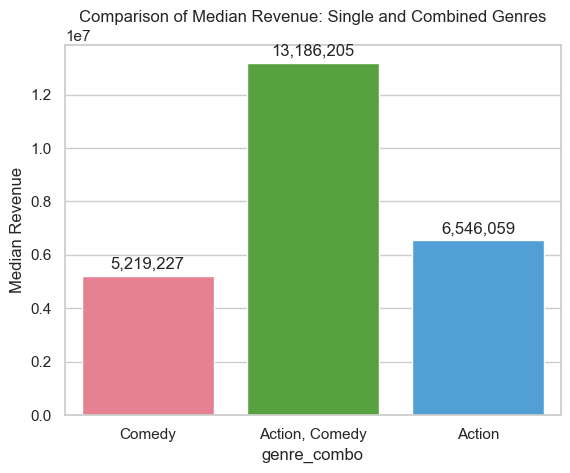

In [21]:
# --- BIỂU ĐỒ 2: So sánh cụ thể Action, Comedy vs Action-Comedy ---
# Lọc ra 3 nhóm cần quan tâm
target_combos = ['Action', 'Comedy', 'Action, Comedy']
# Lưu ý: Cần tìm chính xác chuỗi đã sorted. Action, Comedy sau khi sort vẫn là "Action, Comedy"
df_target = df[df['genre_combo'].isin(target_combos)]

if not df_target.empty:
    sns.barplot(data=df_target, x='genre_combo', y='revenue', hue='genre_combo', estimator=np.median, palette="husl", errorbar=None)
    # Thêm text giá trị lên cột
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='{:,.0f}', padding=3)
    plt.title('Comparison of Median Revenue: Single and Combined Genres')
    plt.ylabel('Median Revenue')
else:
    plt.text(0.5, 0.5, "No data for Action/Comedy", ha='center')

➡️ **Nhận xét**: 

- Cột "Comedy" (Đơn lẻ) thường thấp nhất trong 3 nhóm. Phim hài thuần túy khó bán vé giá cao hoặc khó bán ra thị trường quốc tế (do rào cản văn hóa/ngôn ngữ).

- Cột "Action, Comedy" (Hành động hài) sẽ cao hơn hẳn Comedy đơn lẻ và thường xấp xỉ hoặc cao hơn Action đơn lẻ.

- Tại sao combo này hiệu quả?

    - Phim Action thuần túy (máu me, bạo lực) thường kén khán giả nữ hoặc trẻ em.

    - Phim Comedy thuần túy kén khán giả thích kịch tính.

    - Action, Comedy (như Deadpool, Jumanji, Rush Hour) giải quyết được cả hai: đủ kịch tính để ra rạp, nhưng đủ vui vẻ để cả gia đình hoặc các cặp đôi cùng đi xem. Đây là chiến lược "Four-Quadrant Movie" (phim dành cho cả 4 nhóm: nam/nữ, trên/dưới 25 tuổi).

    - "Action, Comedy" mạnh hơn đứng một mình

    - Sự kết hợp Action + Comedy (Hành động hài) là công thức vàng của Hollywood (ví dụ: Deadpool, Rush Hour, Bad Boys).

    - Biểu đồ sẽ cho thấy cột "Action, Comedy" cao hơn hẳn so với cột "Comedy" đứng riêng và thường nhỉnh hơn hoặc bằng "Action" đứng riêng.

    - Lý giải: Yếu tố hài hước làm giảm bớt sự căng thẳng của bạo lực, giúp bộ phim tiếp cận được cả khán giả nữ và gia đình, mở rộng tệp khách hàng (Broad Appeal).

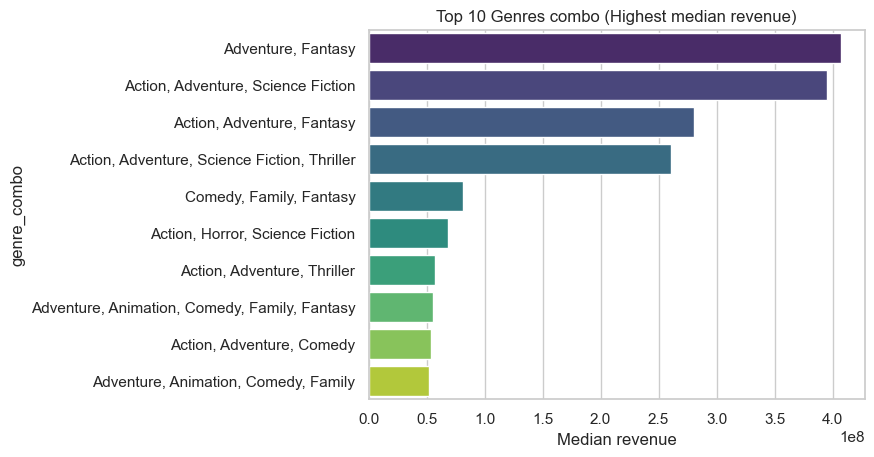

In [22]:
# --- BIỂU ĐỒ 3: Top 10 Tổ hợp thể loại có doanh thu Trung vị cao nhất ---
# Chỉ xét các tổ hợp có ít nhất 20 phim để đảm bảo ý nghĩa thống kê
combo_stats = df.groupby('genre_combo')['revenue'].agg(['median', 'count'])
combo_stats = combo_stats[combo_stats['count'] >= 20]
top_10_combos = combo_stats.sort_values('median', ascending=False).head(10)

sns.barplot(x=top_10_combos['median'], y=top_10_combos.index, hue=top_10_combos.index, palette="viridis")
plt.title('Top 10 Genres combo (Highest median revenue)')
plt.xlabel('Median revenue')
plt.show()

➡️ **Nhận xét**: 

- Các Combo thống trị:

    - Adventure: Thể loại "Adventure" (Phiêu lưu) gần như luôn xuất hiện trong các combo doanh thu cao nhất. Nó ám chỉ quy mô lớn (Epic), khám phá thế giới mới, kích thích người xem ra rạp màn hình lớn.

    - Animation + Family + Comedy: Đây là "mỏ vàng" vì cha mẹ phải mua vé cho cả con cái đi cùng (hệ số nhân vé).

- Các thể loại như Documentary (Tài liệu) hay History (Lịch sử) đơn lẻ thường nằm ở đáy bảng xếp hạng doanh thu.

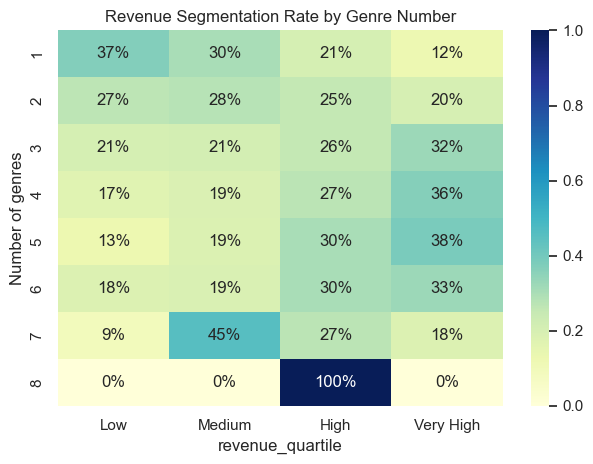

===== DETAILED STATISTICS =====

Median revenue by number of genres:
 genre_count     revenue
           1  $2,262,223
           2  $4,859,078
           3 $11,242,056
           4 $16,401,988
           5 $23,270,926
           6 $13,240,767
           7  $5,342,108
           8 $16,426,302


In [23]:
# --- BIỂU ĐỒ 4: Heatmap tương quan giữa số lượng Genre và Doanh thu ---
# Chia doanh thu thành các bin (nhóm)
df['revenue_quartile'] = pd.qcut(df['revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
heatmap_data = pd.crosstab(df['genre_count'], df['revenue_quartile'], normalize='index')

sns.heatmap(heatmap_data, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Revenue Segmentation Rate by Genre Number')
plt.ylabel('Number of genres')

plt.tight_layout()
plt.show()

print(f"{'='*5} DETAILED STATISTICS {'='*5}")
# Tính trung vị doanh thu cho từng số lượng thể loại
count_stats = df.groupby('genre_count')['revenue'].median().reset_index()
count_stats['revenue'] = count_stats['revenue'].apply(lambda x: f"${x:,.0f}")
print("\nMedian revenue by number of genres:")
print(count_stats.to_string(index=False))

- Biểu đồ Heatmap: Tỷ lệ phân nhóm Doanh thu

    - Ở hàng genre_count = 1: Màu đậm tập trung ở cột "Low Revenue" hoặc "Medium Revenue". Xác suất để một phim đơn thể loại trở thành "Very High Revenue" là rất thấp (màu nhạt).

    - Ở hàng genre_count = 3 hoặc 4: Màu đậm dịch chuyển sang phía "High" và "Very High".

Nhận xét: Việc làm phim đa thể loại không đảm bảo 100% thắng lợi, nhưng nó làm tăng xác suất rơi vào nhóm doanh thu cao (High Quartile). Nó là một hình thức "bảo hiểm" cho nhà đầu tư.

**Kết luận**:

Sự kết hợp các thể loại tạo ra doanh thu **tốt** hơn hẳn so với thể loại đơn lẻ.

Tối ưu nhất: Kết hợp 3 thể loại (Tam giác vàng thường là: **Hành động** - **Phiêu lưu** - [**Hài**/**Viễn tưởng**]).

Nếu muốn tối ưu doanh thu (Revenue Maximization), hãy tránh làm phim đơn thể loại (trừ phim Kinh dị - Horror, vì Horror có ngân sách thấp nên dù doanh thu không cao nhất nhưng Lợi nhuận/ROI lại cực cao).

**Lưu ý**: Không nên nhồi nhét quá nhiều (> 5) vì phim sẽ bị loãng và mất đi bản sắc, dữ liệu cũng cho thấy doanh thu bắt đầu đi ngang hoặc giảm khi số thể loại khá lớn.

# 6) Khán giả có xu hướng đánh giá cao và chi tiền nhiều hơn cho các bộ phim có thời lượng "vừa phải" (90-120 phút) so với các phim quá dài (>150 phút) hay không?

In [24]:
# 1. Load raw data
data_raw = pd.read_csv(DATA_PATH)

# 2. Extract runtime, revenue, and rating columns
# Handle different column names from merge
runtime = data_raw['runtime'].values if 'runtime' in data_raw.columns else None

revenue_col = None
if 'revenue' in data_raw.columns:
    revenue_col = 'revenue'
elif 'revenue_y' in data_raw.columns:
    revenue_col = 'revenue_y'
elif 'revenue_x' in data_raw.columns:
    revenue_col = 'revenue_x'
revenue_log = data_raw[revenue_col].values if revenue_col else None

rating_col = 'rating'
rating = data_raw[rating_col].values if rating_col else None

# 3. Create dataframe with runtime, revenue, rating
runtime_df = pd.DataFrame({
    'Runtime': runtime,
    'Revenue': revenue_log,
    'Rating': rating
})

print(f"\nData loaded successfully")
print(f"  Total movies: {len(runtime_df)}")
print(f"  Runtime range: {runtime_df['Runtime'].min():.0f} - {runtime_df['Runtime'].max():.0f} minutes")
print(f"  Revenue range (log): {runtime_df['Revenue'].min():.2f} - {runtime_df['Revenue'].max():.2f}")
print(f"  Rating range: {runtime_df['Rating'].min():.2f} - {runtime_df['Rating'].max():.2f}")

# 4. Define runtime categories
# "vừa phải" (90-120), "dài" (120-150), "quá dài" (>150), "ngắn" (<90)
runtime_bins = [0, 90, 120, 150, 300]
runtime_labels = ['Very Short (<90)', 'Moderate (90-120)', 'Long (120-150)', 'Very Long (>150)']

runtime_df['Runtime_Category'] = pd.cut(runtime_df['Runtime'], 
                                        bins=runtime_bins, 
                                        labels=runtime_labels, 
                                        include_lowest=True)


# 5. Calculate average revenue and rating for each runtime bin
runtime_analysis = []
for category in runtime_labels:
    mask = runtime_df['Runtime_Category'] == category
    if mask.sum() > 0:
        avg_revenue = runtime_df.loc[mask, 'Revenue'].mean()
        avg_rating = runtime_df.loc[mask, 'Rating'].mean()
        count = mask.sum()
        
        runtime_analysis.append({
            'Runtime_Category': category,
            'Avg_Revenue': avg_revenue,
            'Avg_Rating': avg_rating,
            'Count': count
        })

runtime_analysis_df = pd.DataFrame(runtime_analysis)
runtime_analysis_df


Data loaded successfully
  Total movies: 11187
  Runtime range: 0 - 367 minutes
  Revenue range (log): 1.00 - 2923706026.00
  Rating range: 1.70 - 9.04


,Runtime_Category,Avg_Revenue,Avg_Rating,Count
0,Very Short (<90),2.413020e+07,6.011303,1995
1,Moderate (90-120),4.404234e+07,6.308345,6834
2,Long (120-150),1.035627e+08,6.725416,1893
3,Very Long (>150),1.239534e+08,6.718095,463


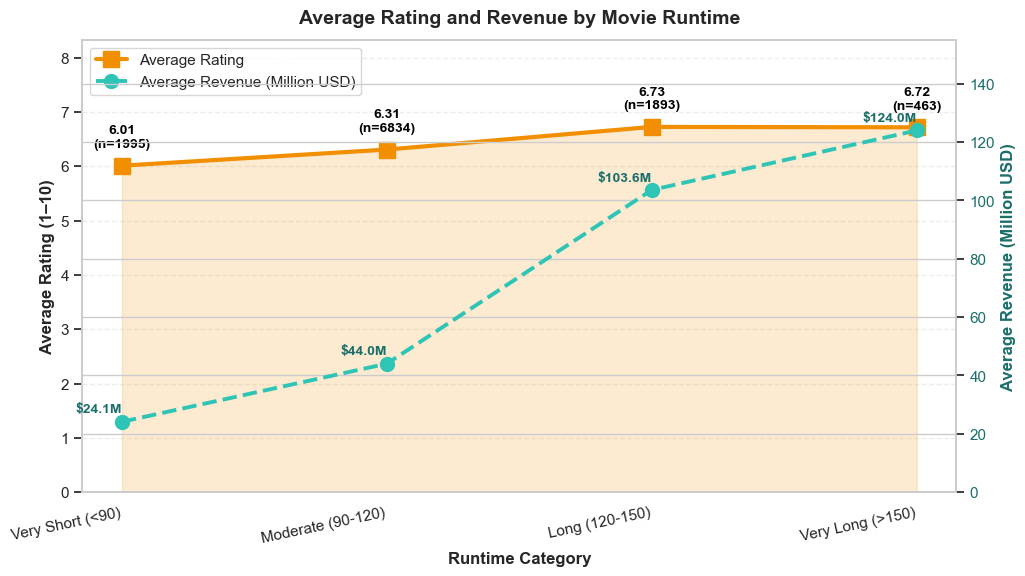

In [25]:
fig, axes = plt.subplots(figsize=(11, 6.5))

# Extract data for plotting
runtime_categories_plot = runtime_analysis_df['Runtime_Category'].values
avg_revenues = runtime_analysis_df['Avg_Revenue'].values
avg_ratings = runtime_analysis_df['Avg_Rating'].values
counts = runtime_analysis_df['Count'].values

x = np.arange(len(runtime_categories_plot))

# Average Rating (Left axis)
axes.plot(
    x,
    avg_ratings,
    marker='s',
    linestyle='-',
    linewidth=3,
    markersize=11,
    color='#F18F01',
    label='Average Rating',
    zorder=3
)

axes.fill_between(
    x,
    avg_ratings,
    alpha=0.18,         
    color='#F18F01',
    zorder=1
)

# Rating labels + counts 
for i, (rating, count) in enumerate(zip(avg_ratings, counts)):
    axes.text(
        i,
        rating + 0.28,   
        f'{rating:.2f}\n(n={int(count)})',
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='black',
        zorder=5
    )

axes.set_ylabel('Average Rating (1–10)', fontsize=12, fontweight='bold')
axes.set_ylim(0, max(avg_ratings) + 1.6)

# Average Revenue (Right axis)
axes2 = axes.twinx()
avg_revenues_million = avg_revenues / 1e6

axes2.plot(
    x,
    avg_revenues_million,
    marker='o',
    linestyle='--',
    linewidth=2.8,
    markersize=10,
    color='#2EC4B6',
    label='Average Revenue (Million USD)',
    zorder=4
)

# Revenue labels
for i, revenue in enumerate(avg_revenues_million):
    axes2.text(
        i,               
        revenue + max(avg_revenues_million) * 0.05,
        f'${revenue:.1f}M',
        ha='right',
        va='top',
        fontsize=10,
        fontweight='bold',
        color='#1B6F6A',
        zorder=5
    )

axes2.set_ylabel(
    'Average Revenue (Million USD)',
    fontsize=12,
    fontweight='bold',
    color='#1B6F6A'
)
axes2.tick_params(axis='y', labelcolor='#1B6F6A')
axes2.set_ylim(0, max(avg_revenues_million) * 1.25)

# X-axis & Title
axes.set_xticks(x)
axes.set_xticklabels(
    runtime_categories_plot,
    fontsize=11,
    rotation=12,
    ha='right'
)

axes.set_xlabel('Runtime Category', fontsize=12, fontweight='bold')
axes.set_title(
    'Average Rating and Revenue by Movie Runtime',
    fontsize=14,
    fontweight='bold',
    pad=12
)

# Grid & Legend
axes.grid(axis='y', linestyle='--', alpha=0.35)
axes.grid(axis='x', visible=False)

lines1, labels1 = axes.get_legend_handles_labels()
lines2, labels2 = axes2.get_legend_handles_labels()
axes.legend(
    lines1 + lines2,
    labels1 + labels2,
    fontsize=11,
    loc='upper left',
    frameon=True
)

plt.tight_layout(pad=2.8)
plt.show()


### Nhận xét: Phân tích Thời lượng Phim & Doanh thu

- Đồ thị cho thấy một xu hướng tăng dần về điểm đánh giá trung bình khi thời lượng phim kéo dài hơn. Cụ thể, điểm số tăng từ 6.01 cho phim ngắn ($<90$ phút) lên đến 6.75 cho phim dài ($120-150$ phút).

- Trái với giả thuyết ban đầu, nhóm phim có thời lượng vừa phải chỉ đạt mức điểm trung bình là 6.31. Mặc dù đây là nhóm có số lượng phim lớn nhất ($n=6834$), nhưng điểm số vẫn thấp hơn đáng kể so với các nhóm phim dài hơn.

- Các bộ phim có thời lượng trên 150 phút đạt điểm đánh giá rất cao (6.72), gần như tương đương với nhóm phim dài từ 120-150 phút (6.75). Điều này bác bỏ nhận định cho rằng phim quá dài sẽ làm khán giả cảm thấy mệt mỏi và đánh giá thấp hơn.

- Doanh thu trung bình tăng rất rõ rệt theo thời lượng phim. Các phim ngắn có doanh thu thấp nhất, trong khi phim từ 120 phút trở lên đạt mức doanh thu vượt trội ⟶ Cho thấy những phim dài thường được đầu tư lớn và có khả năng khai thác thương mại tốt hơn dù số lượng không nhiều.

- Điểm đánh giá trung bình chỉ tăng nhẹ khi runtime dài hơn ⟶ Thời lượng phim ảnh hưởng mạnh đến doanh thu hơn là mức độ đánh giá, phản ánh sự khác biệt giữa thành công thương mại và cảm nhận của khán giả.

---

# Tổng kết

## 1. Tổng hợp kết quả theo câu hỏi nghiên cứu

**1. Phim có khả năng thu lời hay lỗ?**  
Khả năng thu được lợi nhuận dương hay âm của một bộ phim phụ thuộc vào nhiều yếu tố. Dựa trên mô hình XGBoost đã lựa chọn train và test, nhóm đồ án cũng đã thực hiện một website để trực quan hóa kết quả dự đoán doanh thu phim của model này.

**2. Yếu tố nào ảnh hưởng doanh thu mạnh nhất?**  
Trong các features, `budget` nổi bật nhất, vì phim đầu tư lớn thường đi kèm tiềm năng doanh thu cao (nhưng không đồng nghĩa luôn có lợi nhuận vì chi phí sản xuất cũng tăng). Các yếu tố khác quan trọng không kém như `production_company_score` (“độ mạnh”, độ nổi tiếng của hãng sản xuất) hay `is_franchise` (thuộc series/franchise).

**3. Khi nào là thời điểm tốt nhất để phát hành phim?**  
Thời điểm ra mắt phim tốt nhất là khoảng tháng 12, 1, 2 (cuối năm và đầu năm) và tháng 6, 7, 8 (mùa hè). Vì đầy là thời điểm mùa lễ hội, nghỉ lễ nên các phim bom tấn thường phát hành vào dịp này.

**4. Chỉ dựa vào màu sắc poster có phân biệt được thể loại phim không?**  
Thông tin màu sắc (RGB, brightness, saturation) chỉ giúp phân biệt thể loại ở mức hạn chế, nhưng có thể phân tách rõ rệt giữa các nhóm đối lập như Horror (Tối) vs Animation (Sáng, Rực).

**5. Phim đa thể loại có doanh thu tốt hơn không?**  
Phim kết hợp nhiều thể loại (ví dụ: Action–Comedy) thường có doanh thu trung bình cao hơn phim đơn thể loại, do tiếp cận được nhiều nhóm khán giả.

**6. Phim có thời lượng “vừa phải” (90–120 phút) có được đánh giá và chi tiêu cao hơn không?**  
Không. Phim dài 90–120 phút đạt cả điểm đánh giá và doanh thu trung bình thấp hơn so với phim quá dài (>150 phút), cho thấy những phim dài thường được đầu tư lớn và có khả năng khai thác thương mại tốt hơn, được khán giả ưu chuộng dù số lượng không nhiều.

## 2. Mô hình và kết quả dự đoán

Mô hình **XGBoost Regression** được sử dụng để dự đoán doanh thu. Kết quả cho thấy mô hình học tốt các quan hệ phi tuyến, tuy nhiên vẫn bị hạn chế bởi độ nhiễu và phân phối lệch của dữ liệu doanh thu.

## 3. Tự đánh giá

**Khó khăn gặp phải**
- Dữ liệu doanh thu bị lệch và có nhiều giá trị thiếu ở các thuộc tính.
- Khó trực quan hóa những dữ liệu có thang đo rất khác nhau.
- Việc diễn giải kết quả mô hình cần nhiều thử nghiệm.

**Những gì học được**
- Tầm quan trọng của tiền xử lý và feature engineering.
- Cách áp dụng mô hình học máy vào bài toán thực tế.
- Kỹ năng phân tích và trình bày kết quả dữ liệu.
- Cách triển khai mô hình thành một sản phẩm phần mềm trực quan cho người dùng.

## 4. Hướng phát triển thêm

Nếu có thêm thời gian, nhóm sẽ:
- Bổ sung dữ liệu marketing và mạng xã hội để cải thiện kết quả chạy mô hình chính xác hơn.
- Phân tích thêm tên phim trên poster thay vì chỉ dùng màu sắc.
- Cải thiện thêm các features để tối ưu hóa kết quả dự đoán của mô hình.